# <a id='toc1_'></a>[OpenVINO™ Explainable AI Toolkit: Classification Explanation](#toc0_)


**OpenVINO™ Explainable AI (XAI) Toolkit** provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

This notebook shows an example of how to use OpenVINO XAI Toolkit and interpret the resulting saliency maps. 

It depicts a heatmap with areas of interest where neural network (classification or detection) focuses before making a desicion. 

This notebook shows which saliency map are generated in different scenarios, in case of correct and confident prediction, in case of low-confident prediction and in case of mixed up classes. 

**Table of contents**<a id='toc0_'></a>    
- [OpenVINO™ Explainable AI Toolkit: Classification Explanation](#toc1_)    
- [Imports](#toc2_)    
- [Download dataset](#toc3_)    
- [Prepare IR model](#toc4_)    
  - [Download model from OpenVINO storage](#toc4_1_)    
  - [Insert XAI branch](#toc4_2_)    
- [Create model inferrer](#toc5_)    
- [Explain model](#toc6_)    
  - [Import ImageNet label names and add them to saliency maps](#toc6_1_)    
  - [Notable usecases in ImageWoof dataset](#toc6_2_)    
    - [Naming logic](#toc6_2_1_)    
    - [True Positive High confidence](#toc6_2_2_)    
    - [True Positive Low confidence](#toc6_2_3_)    
    - [False Positive High confidence](#toc6_2_4_)    
    - [Two mixed predictions](#toc6_2_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
import json
import os
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino.runtime as ov
import openvino_xai as xai

from openvino_xai.common.utils import retrieve_otx_model
from openvino_xai.explainer.utils import ActivationType

# <a id='toc3_'></a>[Download dataset](#toc0_)

To see the examples of saliency maps for different usecases, please download the ImageWoof datatet using code below:

In [2]:
# Download 330 MB of 320 px ImageNet subset with dogs breeds
! wget -P ../../data https://ultralytics.com/assets/imagewoof320.zip
! unzip ../../data/imagewoof320.zip -d ../../data/imagewoof320

In [2]:
# Create list of images
img_data_formats = (".jpg", ".jpeg", ".JPEG", ".gif", ".bmp", ".tif", ".tiff", ".png")

img_files = []
image_folder_path = "../../data/imagewoof320/imagewoof320/val"
output = Path("saliency_map/imagewoof320")

# image_folder_path is a directory (with sub-folder support)
for root, _, _ in os.walk(image_folder_path):
    for format_ in img_data_formats:
        img_files.extend(
            [os.path.join(root, file.name) for file in Path(root).glob(f"*{format_}")]
        )
print(f"Number of images to get explanations: {len(img_files)}")

# Get a fewer subset for fast execution
img_files = random.sample(img_files, 3)
print(f"Run explanations on fewer number of images: {len(img_files)}")

Number of images to get explanations: 3929
Run explanations on fewer number of images: 3


# <a id='toc4_'></a>[Prepare IR model](#toc0_)

## <a id='toc4_1_'></a>[Download model from OpenVINO storage](#toc0_)

In this notebook we will use the model already converted to IR and placed in OpenVINO storage.

In [3]:
# Download test IR (.bin+.xml) model from our repository or use your own
retrieve_otx_model(
    ".",  # Destination folder
    "mobilenetv3_large_100.ra_in1k",  # Model name
    dir_url="https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification",
)

# Please manually check the size of the downloaded model to be more than 2 KB
model_path = "./otx_models/mobilenetv3_large_100.ra_in1k.xml"

## <a id='toc4_2_'></a>[Insert XAI branch](#toc0_)

To receive explanations (saliency maps) from the model, first we need to insert the XAI branch. This will create an extra output for model, a low resolution saliency map. It later can be postprocessed, resized and applied over an original image, using `PostProcessor` component of the `OpenVINO XAI` Toolkit.

In [4]:
# Create original ov.Model
model: ov.Model
model = ov.Core().read_model(model_path)

# Insert XAI branch
model_xai: ov.Model
model_xai = xai.insert_xai(
    model,
    task=xai.Task.CLASSIFICATION,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).


INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


# <a id='toc5_'></a>[Create model inferrer](#toc0_)

After the model is updated with explainable (XAI) branch, it can be used in your own pipelines. For example, let's create a custom inferencer similar to those that can be done in personal product pipelines.

For an example of creating callable the `CustomModelInferrer` class, that can be updated based on your pipeline, refer to [model_inferrer.py](../../openvino_xai/explanation/model_inferrer.py)

In [5]:
model_inferrer = xai.explanation.model_inferrer.ClassificationModelInferrer(
    model_xai,
    # Preprocessing for timm models
    mean=np.array([123.675, 116.28, 103.53]),
    std=np.array([58.395, 57.12, 57.375]),
    activation=ActivationType.SOFTMAX,
)

# <a id='toc6_'></a>[Explain model](#toc0_)

## <a id='toc6_1_'></a>[Import ImageNet label names and add them to saliency maps](#toc0_)

If model doesn't have a label list in meta information, the saved saliency map will have the predicted class index, not name. For example,  `n02089973_3688_target_167.jpg` instead of `n02089973_3688_target_English_foxhound.jpg`. 

To see the predicted label name more conveniently, let's add ImageNet label list info into explaination parameters. 

In [6]:
%%capture
! wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [7]:
# Get ImageNet labels to add them to explanations

f = open("imagenet_classes.txt", "r")
imagenet_labels = []
for label in f.readlines():
    class_label = label.replace(" ", "_")[:-1]
    imagenet_labels.append(class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


In [10]:
# Create explanation_parameters, adding list with ImageNet labels
explanation_parameters = ExplanationParameters(
    visualization_parameters=VisualizationParameters(overlay=True),
    explain_target_names=imagenet_labels,
)

# Explain model and save results using ImageNet label names
for image_path in img_files:
    image = cv2.imread(image_path)
    try:
        explanation = xai.explain(
            model_inferrer=model_inferrer,
            data=image,
            explanation_parameters=explanation_parameters,
        )
        explanation.save(output / "label_names", Path(image_path).stem)
    except ValueError:
        pass

Below in `output / "label_names"` you can see saved saliency maps:

In [11]:
# See saliency mas saved in `output` with predicted label in image name
! ls -l saliency_map/imagewoof320/label_names

total 100
-rw-r--r-- 1 gzalessk gzalessk 27095 Feb  7 23:47 n02086240_5731_target_West_Highland_white_terrier.jpg
-rw-r--r-- 1 gzalessk gzalessk 71271 Feb  7 23:47 n02088364_3900_target_beagle.jpg


## <a id='toc6_2_'></a>[Notable usecases in ImageWoof dataset](#toc0_)

Below a few examples were chosen to show cases, when:
- The correct class was predicted with the high confidence (`True Positive, high confidence`)
- The correct class was predicted, but with the low confidence for some reason (`True Positive, low confidence`)
- The predicted class has a high confidence, but was incorrect, one class was treated as the other one (`False positive, high confidence`)
- Two classes were predicted with rather same high confidence with the different saliency maps for each of them (`Two predictions`)

The `imagewoof_usecases.json` contains paths to images with those respective use cases:

In [12]:
# Read file with paths to noticable usecases
with open("imagewoof_usecases.json", "r") as f:
    usecases_image_paths = json.load(f)

In [13]:
# Add mapping from folder to label to define the ground-truth label from name
label_mapping = {
    "n02088364": "beagle",
    "n02099601": "golden retriever",
    "n02105641": "Old English sheepdog",
    "n02111889": "Samoyed",
    "n02086240": "Shih-Tzu",
    "n02089973": "English foxhound",
    "n02087394": "Rhodesian ridgeback",
    "n02096294": "Australian terrier",
    "n02115641": "dingo",
}

In [14]:
output_dir = Path("saliency_map/imagewoof320")

# Run explanation for chosen paths
for usecase in usecases_image_paths:
    image_paths = usecases_image_paths[usecase]["paths"]
    usecase_conf_thr = usecases_image_paths[usecase]["confidence"]

    explanation_parameters = ExplanationParameters(
        visualization_parameters=VisualizationParameters(overlay=True),
        confidence_threshold=usecase_conf_thr,
        explain_target_names=imagenet_labels,
    )

    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_name = Path(image_path).stem
        folder_name = image_name.split("_")[0]
        gt_class = label_mapping[folder_name]
        try:
            explanation = xai.explain(
                model_inferrer=model_inferrer,
                data=image,
                explanation_parameters=explanation_parameters,
            )

            for label_ind, conf in explanation.prediction:
                if imagenet_labels[label_ind] == gt_class:
                    gt_conf = conf
            gt_info = f"gt_{gt_class}_{gt_conf:.2f}"

            print(
                f"Predicted class index and its probability: {explanation.prediction}"
            )
            explanation.save(
                output_dir / usecase, f"{image_name}_{gt_info}", return_confidence=True
            )
        except ValueError:
            print(f"Explanation for {image_path} failed: no predictions were found")

Predicted class index and its probability: [(162, 0.96238923)]
Predicted class index and its probability: [(207, 0.7974112)]
Predicted class index and its probability: [(229, 0.9918407)]
Predicted class index and its probability: [(258, 0.9140097)]
Predicted class index and its probability: [(155, 0.54905653)]
Predicted class index and its probability: [(155, 0.9334737)]
Predicted class index and its probability: [(155, 0.52746975)]
Predicted class index and its probability: [(207, 0.43573648)]
Explanation for ../../data/imagewoof320/imagewoof320/train/n02087394/n02087394_6357.JPEG failed: no predictions were found
Predicted class index and its probability: [(421, 0.9534185)]
Predicted class index and its probability: [(475, 0.7669864)]
Predicted class index and its probability: [(750, 0.8003972)]
Explanation for ../../data/imagewoof320/imagewoof320/train/n02099601/n02099601_4933.JPEG failed: no predictions were found
Predicted class index and its probability: [(537, 0.871866)]
Predict

The function below helps to visualise the results, creating the matrix of pictures, its names and the confidence of predictions:

In [15]:
# Function to show result images for each usecase


def show_usecase_image(usecase):
    usecase_output_dir = output_dir / usecase

    image_paths = os.listdir(usecase_output_dir)
    number_images = len(image_paths)

    fig, axs = plt.subplots((number_images + 1) // 2, 2, figsize=(10, 10))
    fig.tight_layout()
    fig.suptitle(usecase)
    fig.subplots_adjust(top=0.88)
    axs = axs.flatten()

    for ind, (image_path, ax) in enumerate(zip(image_paths, axs)):
        image_sal_map = cv2.imread(f"{usecase_output_dir}/{image_path}")
        image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)

        ax.imshow(image_sal_map)
        ax.set_title(f"{ind+1}\n{image_path}", wrap=True)
        ax.axis("off")

    if number_images % 2 == 1:
        axs[-1].set_visible(False)

    plt.show()

See the list of usecase names:

In [16]:
print(f"Names of usecases: {list(usecases_image_paths.keys())}")

Names of usecases: ['tp_high_conf', 'tp_low_conf', 'fp_high_conf', 'tp_two_preds']


### <a id='toc6_2_1_'></a>[Naming logic](#toc0_)

The name of saved saliency maps in this notebook contains info about ground-thruth class, predicted class and its confidence. For better understanding, let's split the name onto meaningful parts and learn its meaning, taking `n02115641_5752_gt_dingo_0.18_target_Chihuahua_0.93` as an example.

`n02115641_5752` - the original name of the image.

`gt_dingo_0.18` - `ground-truth` info, the image was annotated as `dingo` class and model predicted this class with `0.18` confidence.

`target_Chihuahua_0.93` - `predicted` info, the winning class is `Chihuahua` and the model made this prediction with `0.93` confidence.


### <a id='toc6_2_2_'></a>[True Positive High confidence](#toc0_)

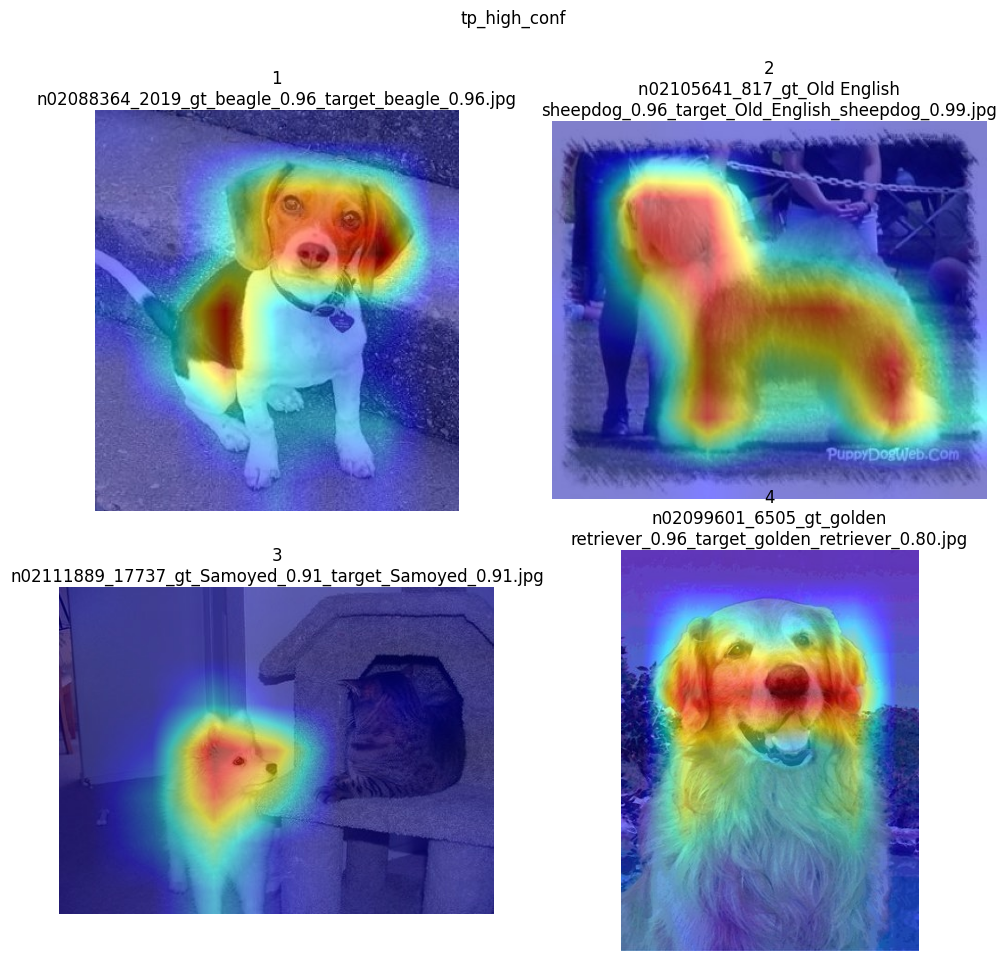

In [17]:
show_usecase_image("tp_high_conf")

In these cases of `True positive high confidence` the saliency maps are considered to be canonical. 

The areas of attention are focused around the ground truth object highlighting the most important features to udentify the class like face shape, nose and ears and also the general shape of the dog. 

Another sign that predicted saliency map are high-quality is that classes are separate enough, meaning that it doesn't highlight objects of the other classes, like the `cat` class on the 3th image.

### <a id='toc6_2_3_'></a>[True Positive Low confidence](#toc0_)

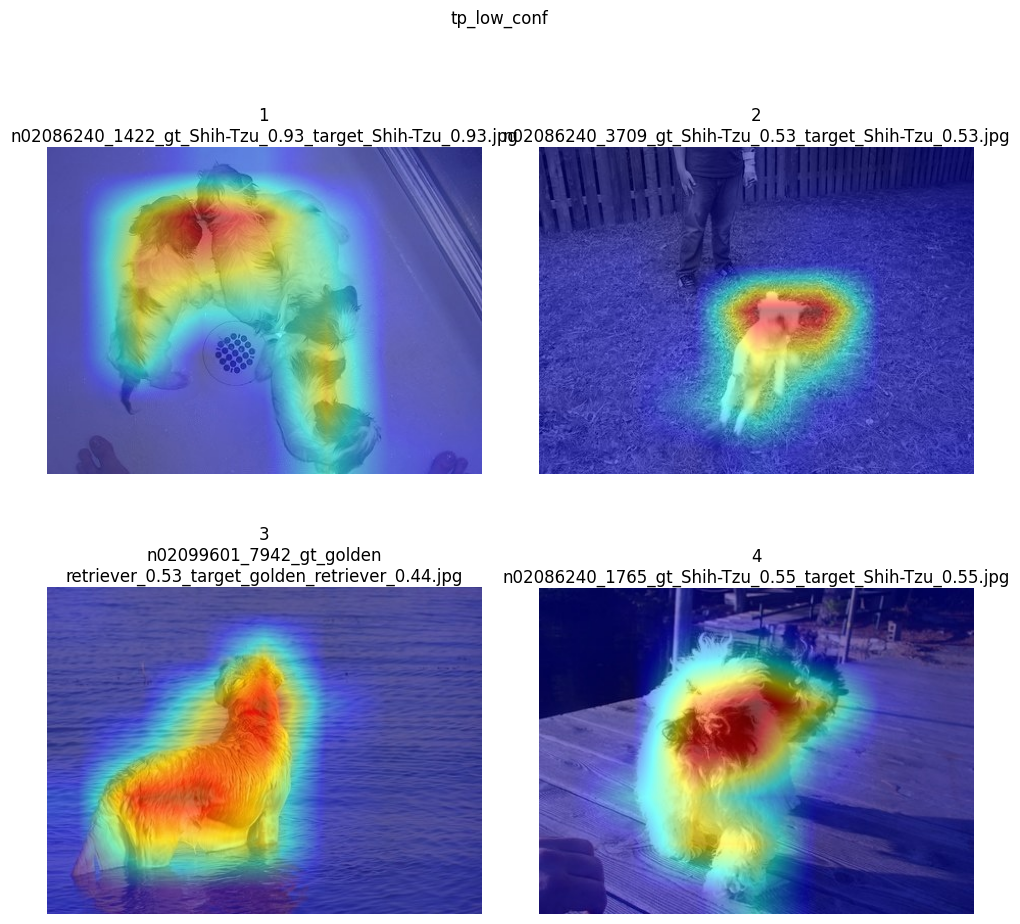

In [18]:
show_usecase_image("tp_low_conf")

If objects are not focused enough or needed features aren't seen, the `confidence` is decreasing. The model's attention highlight the whole object, trying to make  a decision based on high level features. It makes the prediction confidence lower and in case of high `confidence treshold`, such predictions can be filtered out.

### <a id='toc6_2_4_'></a>[False Positive High confidence](#toc0_)

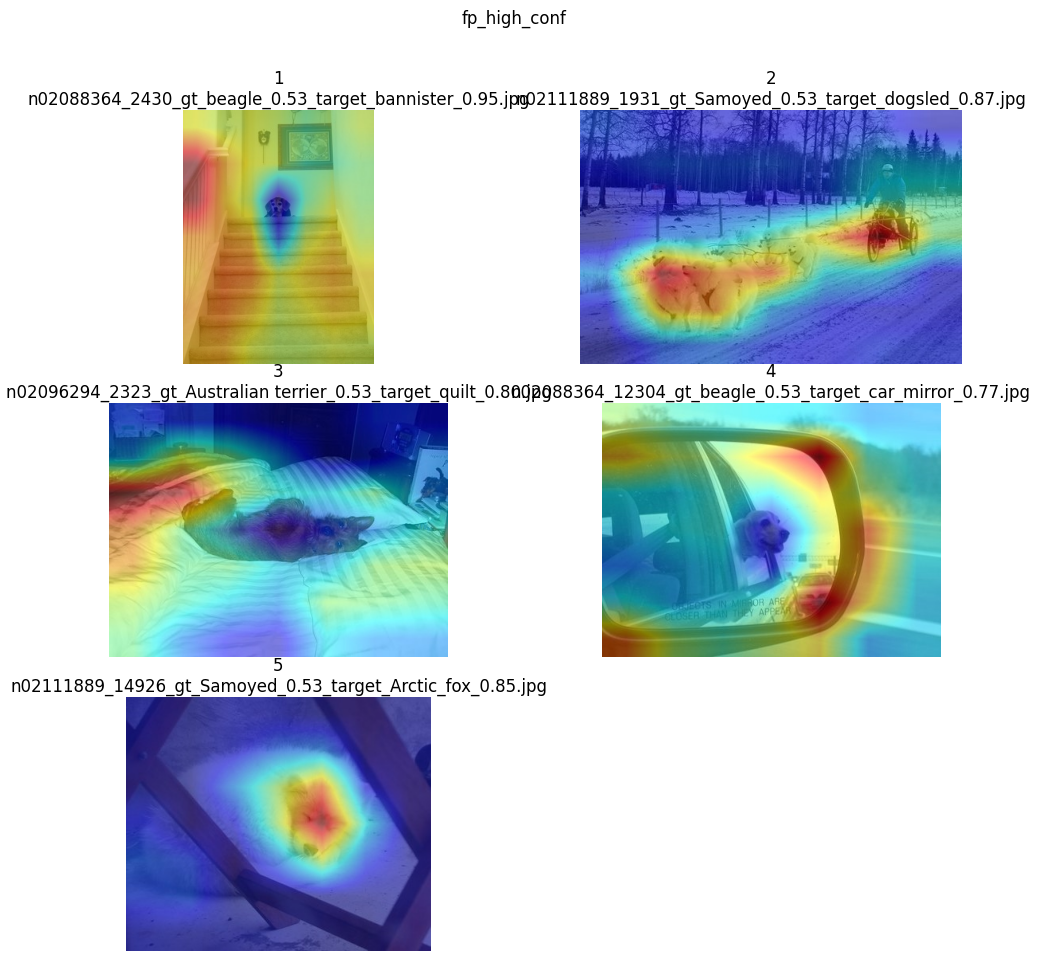

In [19]:
show_usecase_image("fp_high_conf")

Here we see a few different reasons why model can one class instead of another:

- There are objects of 2 classes represented on the image and one of the class is much more obvious than another. For example, it's larger or on the foreground.
We can see it on the 1st image (`bannister` instead of `beagle`), 2nd (`dogsled` instead of `samoyed`), 3rd (`quilt` instead of `Australian terrier`), 4th (`car mirror` instead of `beagle`).
<!-- We can see it on the 2nd image (`bubbles` are predicted instead of `golden retreiver`), 3rd (`bassinet` instead of `beagle`), 4th (`carr mirror` instead of `beagle`), 5th (`blanket` instead of `terrier`), 6th (`dogsled` instead of `samoyed`). -->

We can see that it's not the problem of the model but rather the characteristic of the picture itself.

- Two classes looks similar in the specific shooting settings.

On the 5th picture sleeping `samoyed` was confused with `arctic fox` because the sleeping position distorted the key features, so classes look even more alike then usual.

<!-- On the 1st picture the big `dingo` dog was confused with small `chihuahua` focusing only on the face features. On the 7th picture sleeping `samoyed` was confused with `arctic fox` because the sleeping position distorted the key features, so classes look even more alike then usual. On the 8th picture shadows created a pattern on the dog, so model found key features for `dalmatian` class and predicted it with the high confidence. -->

Here we see that model is well-trained and mixes classes only because of intricate shooting conditions and presence of more than 1 class on the picture.

### <a id='toc6_2_5_'></a>[Two mixed predictions](#toc0_)

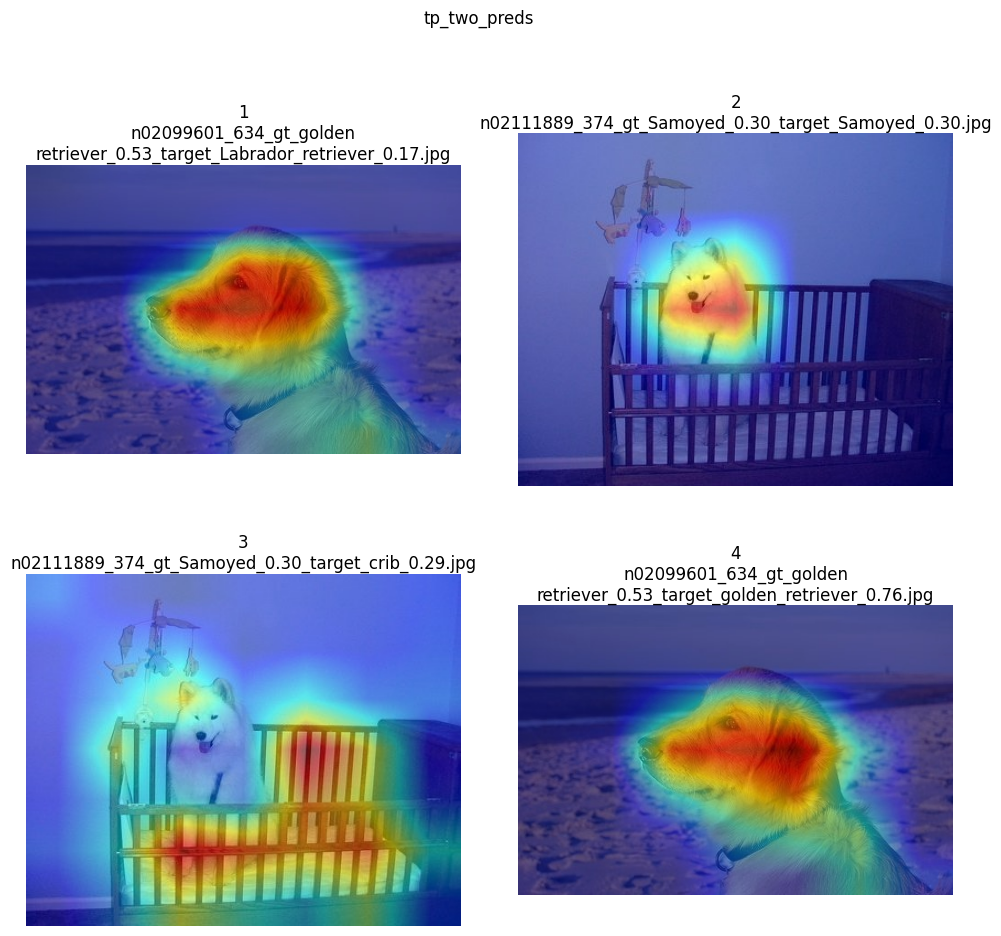

In [21]:
show_usecase_image("tp_two_preds")

Here are the examples where two classes are predicted with relatively high confidence and model is sure about both of them. We can see how saliency maps are different for each class.

On the 2nd-3th image both `samoyed` and `crib` are well-seen, so model cannot decide between these 2 classes. We clearly see the different areas of interest for each of these classes.

On the 1st-2nd picture model can't decide between `golden retreiver` and `labrador` focusing on the whole face shape.